# **Covid-19 Pandemic**

The Covid-19 pandemic has affected everyone in the world and we will explore the effect of the virus in each country, deaths caused by it and how the vaccine distribution has been unequal. We will also compare the effect of the virus in relation to the Gross Domestic Product(GDP) per capita, population and population densities of the countries. 

### **Contents**

1. Introduction
2. Data Inspection and Cleaning
3. Data Analysis
4. Conclusions
5. References


### **1. Introduction**

Covid-19 is a disease caused by the SARS-CoV-2 virus found in animals that has found its way into humans. Since the virus is airborne, it can easily pass from one human to another which is why it has affected every country in the world in such a short amount of time (CDC 2021). 

Currently there have been more than 265 million cases and 5.25 million deaths. Due to the devastating effects of the virus, governments and companies all over the world have put extra resource and focus on the vaccine that can help cure, reduce symptoms and prevent deaths (Australia Government 2021). Many vaccines have been approved and more than 7 billion doses have been administered so far. 

While that number may sound optimistic, vaccine distribution has not been equal with poorer countries with poor health infrustructure, where people are more susceptible to the devastating effects of the virus (Hyder et al, 2021), not having received their fair share of the vaccines. 

This analysis is done to understand the effect of the virus, vaccine and the distribution of the vaccine. 

The data has been collected from various reliable sources such as, Kaggle and the World Health Organization website. The team organises the data from various sources but there have been some limitations with the data as not all countries update their case and vaccine numbers regularly. Regardless, the data has helped us uncover useful insights. The questions we will be answering are:



1. With time, how has the number deaths due to the virus changed and how has it changed as more vaccines have been administered?
2. For each country, how many cases do they have per 10,000 people?
3. How does the GDP of a country relate to how many cases they have?
4. What effect does population density have on how many cases a country has?
5. How has the vaccine distribution been for countries of different income level compared to population of those countries?
6. Focussing on the inequality in vaccine distribuion, let us see how big is the vaccine distribution gap between a high income and a low income country.

Source of data:


* CovidCasesAndDeaths.csv - Data obtained from [WHO](https://covid19.who.int/info/) (WHO, 2021) website
* CovidVax.csv - Data obtained from [Kaggle](https://www.kaggle.com/rsrishav/world-population) (Sharma R, 2021)
* GDP.csv - Data obtained from [World Bank](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD) (The World Bank, 2021)
* Population.csv - Data obtained from [Kaggle](https://www.kaggle.com/saurabhag12/country-vaccinations) (Saurabh, 2021)

### **2. Data Inspection and Cleaning**


In [1]:
# Start by importing required modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
import numpy as np
import geopandas
import geoplot
import plotly.express as px

#to ensure numbers are displayed fully
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

We have four datasets that we will be using in this project. The common link across all the files is the Country name or the ISO code of the countries. We will explore all the datasets in this section and clean up the data as required. 

In [2]:
# Import the required data
cases_df = pd.read_csv("CovidCasesAndDeaths.csv")
population_df = pd.read_csv("Population.csv")
vax_df = pd.read_csv("CovidVax.csv")
income_df = pd.read_csv("GDP.csv")

In [3]:
#Taking a quick look at the Cases dataframe
print(cases_df.columns.is_unique)
print(cases_df.shape)
print(cases_df[cases_df.duplicated() == True])
cases_df.head()

True
(165900, 8)
Empty DataFrame
Columns: [Date_reported, Country_code, Country, WHO_region, New_cases, Cumulative_cases, New_deaths, Cumulative_deaths]
Index: []


,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


The data looks good. We will remove the columns WHO_region and Country_code as it is unnecessary for our analysis. 

We also have to change the Date datatype from object to date since it will be required in out time-series analysis. 

In [4]:
#drop the two columns
cases_df = cases_df.drop(
    ['WHO_region', 'Country_code'],
    axis = 1,
    errors = 'ignore' 
)

#renaming the column to Date
cases_df = cases_df.rename(columns={'Date_reported': 'Date'}, errors = 'ignore')

#changing the datatype
cases_df['Date'] = pd.to_datetime(cases_df.Date)




We will look at the data about vaccinations now. The original data had more columns regarding the type of vaccine used and the source of data which were removed before uploading the data due to size limits.  

In [5]:
print(vax_df.columns.is_unique)
print(vax_df.shape)
print(vax_df[vax_df.duplicated() == True])
vax_df

True
(60269, 12)
Empty DataFrame
Columns: [country, iso_code, date, total_vaccinations, people_vaccinated, people_fully_vaccinated, daily_vaccinations_raw, daily_vaccinations, total_vaccinations_per_hundred, people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred, daily_vaccinations_per_million]
Index: []


,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
0,Afghanistan,AFG,2021-02-22,0.000,0.000,NaN,NaN,NaN,0.000,0.000,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.000,NaN,NaN,NaN,34.000
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.000,NaN,NaN,NaN,34.000
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.000,NaN,NaN,NaN,34.000
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.000,NaN,NaN,NaN,34.000
...,...,...,...,...,...,...,...,...,...,...,...,...
60264,Zimbabwe,ZWE,2021-11-22,6433842.000,3681490.000,2752352.000,14138.000,34791.000,42.630,24.390,18.240,2305.000
60265,Zimbabwe,ZWE,2021-11-23,6454719.000,3697233.000,2757486.000,20877.000,32371.000,42.770,24.500,18.270,2145.000
60266,Zimbabwe,ZWE,2021-11-24,6486873.000,3719630.000,2767243.000,32154.000,31085.000,42.980,24.650,18.340,2060.000
60267,Zimbabwe,ZWE,2021-11-25,6513046.000,3738317.000,2774729.000,26173.000,28945.000,43.160,24.770,18.390,1918.000


Date is an object field but we will change it to date field as it  will be required for our time-series analysis. 

In [6]:
#Rename the columns for consistency
vax_df = vax_df.rename(columns={'country': 'Country', 'date': 'Date'})

#Change the date type
vax_df['Date'] = pd.to_datetime(vax_df.Date)


Now we will take a look at GDP per capita data. It gives us information about the average income of the population of each country. 

In [7]:
print(income_df.columns.is_unique)
print(income_df.shape)
print(income_df[income_df.duplicated() == True])
income_df

True
(266, 65)
Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Index: []

[0 rows x 65 columns]


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24985.014,24712.493,26441.620,26893.012,28396.908,28452.171,29350.805,30253.279,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,147.837,147.239,156.427,182.521,162.595,180.489,...,1686.696,1672.364,1653.188,1658.650,1507.800,1404.953,1540.232,1534.172,1485.307,1330.140
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773,59.861,58.458,78.706,82.095,101.108,...,591.163,641.871,637.165,613.857,578.466,509.220,519.889,493.757,507.103,508.808
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,107.964,113.115,118.866,123.479,131.893,138.567,...,1827.518,1936.391,2123.392,2166.743,1886.248,1666.422,1606.978,1695.959,1772.339,1714.427
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4615.468,5100.097,5254.881,5408.412,4166.980,3506.073,4095.810,3289.644,2809.626,1895.771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3741.875,3596.805,3891.266,4080.331,3603.026,3780.004,4045.614,4419.914,4445.891,4287.201
262,"Yemen, Rep.",YEM,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1374.621,1446.536,1607.152,1674.003,1601.830,1138.604,960.529,824.118,NaN,NaN
263,South Africa,ZAF,GDP per capita (current US$),NY.GDP.PCAP.CD,443.010,454.962,473.011,511.497,548.996,584.704,...,8007.476,7501.661,6832.726,6433.400,5734.633,5272.544,6131.479,6372.606,6001.401,5090.715
264,Zambia,ZMB,GDP per capita (current US$),NY.GDP.PCAP.CD,232.189,220.042,212.578,213.897,242.384,303.282,...,1672.908,1763.069,1878.347,1762.428,1338.291,1280.807,1535.197,1516.371,1305.002,1050.919


We will only be looking at data from 2020 which is the year the pandemic started. We can remove all the columns of other years, Indicator Name and Indicator Code.

In [8]:
income_df = income_df.drop(
    ['Indicator Name', 'Indicator Code'],
    axis = 1,
    errors = 'ignore' 
)

#renaming column names for consistency
income_df.rename({'Country Name': 'Country', 'Country Code': 'iso_code',  '2020': '2020 Income'}, axis=1, inplace=True)


Some countries have NaN values in 2020. We will assume the value of the previous years which had a income reported before dropping the columns. Some countries have 2019 data missing too. So for consistency we will fill 2020 NaN values with that of 2018.

In [9]:
income_df['2020 Income'].fillna(income_df['2018'], inplace=True)

# Drop all cloumns from 'Indicator Name' to '2019'
income_df.drop(columns=income_df.columns[2:62],inplace=True)

In [10]:
income_df[income_df['2020 Income'].isnull()]

,Country,iso_code,2020 Income
38,Channel Islands,CHI,NaN
69,Eritrea,ERI,NaN
84,Gibraltar,GIB,NaN
110,Not classified,INX,NaN
147,St. Martin (French part),MAF,NaN
172,New Caledonia,NCL,NaN
193,"Korea, Dem. People's Rep.",PRK,NaN
199,French Polynesia,PYF,NaN
216,South Sudan,SSD,NaN
227,Syrian Arab Republic,SYR,NaN


There are some countries that do not have any information regarding their GDP for multiple years. We will be dropping those countries altogether from the table. 

In [11]:
income_df = income_df.dropna(axis=0, subset=['2020 Income'])

In [12]:
income_df['2020 Income'].isnull().any()

False

All null values have been removed

Now we will take a look at population data.


In [13]:
print(population_df.columns.is_unique)
print(population_df.shape)
print(population_df[population_df.duplicated() == True])
population_df

True
(224, 9)
Empty DataFrame
Columns: [iso_code, country, 2021_last_updated, 2020_population, area, density_sq_km, growth_rate, world_%, rank]
Index: []


,iso_code,country,2021_last_updated,2020_population,area,density_sq_km,growth_rate,world_%,rank
0,CHN,China,"1,446,206,025","1,439,323,776","9,706,961 sq_km",149/sq_km,0.34%,18.34%,1
1,IND,India,"1,398,927,522","1,380,004,385","3,287,590 sq_km",424/sq_km,0.97%,17.69%,2
2,USA,United States,"333,713,599","331,002,651","9,372,610 sq_km",36/sq_km,0.58%,4.23%,3
3,IDN,Indonesia,"277,531,951","273,523,615","1,904,569 sq_km",145/sq_km,1.04%,3.51%,4
4,PAK,Pakistan,"226,963,317","220,892,340","881,912 sq_km",255/sq_km,1.95%,2.86%,5
...,...,...,...,...,...,...,...,...,...
219,MSR,Montserrat,"4,977","4,992",102 sq_km,49/sq_km,-0.30%,0.00%,228
220,FLK,Falkland Islands,"3,533","3,480","12,173 sq_km",0/sq_km,1.52%,0.00%,229
221,NIU,Niue,"1,619","1,626",260 sq_km,6/sq_km,-0.43%,0.00%,230
222,TKL,Tokelau,"1,373","1,357",12 sq_km,114/sq_km,1.18%,0.00%,231


We will not be requiring growth_rate, world% and rank so we will drop those.

In [14]:
population_df = population_df.drop(
    ['growth_rate', 'world_%', 'rank'],
    axis = 1,
    errors = 'ignore'
)


In [15]:
population_df = population_df.rename(columns={'country': 'Country'})
population_df = population_df.rename(columns={'2021_last_updated': '2021 Population'})

We will check if '2021 Population' has any null values. Any missing value will be replaced with 2020 population data and then 2020_population will be dropped.

In [16]:
population_df['2021 Population'].isnull().any()
population_df = population_df.drop(
    ['2020_population', 'area'],
     axis = 1,
     errors = 'ignore'
)


We will change the population data and density data to float numbers as they will be required for calculations in our analysis.

In [17]:
#removing the '/sq_km' and ',' from the density_sq_km column
population_df["density_sq_km"]=population_df["density_sq_km"].str.replace('/sq_km','')
population_df["density_sq_km"]=population_df["density_sq_km"].str.replace(',','')

#removing the ',' from the popultion column
population_df["2021 Population"]=population_df["2021 Population"].str.replace(',','')

#converting to float
population_df['density_sq_km'] = population_df['density_sq_km'].astype(str).astype(float)
population_df['2021 Population'] = population_df['2021 Population'].astype(str).astype(float)

### **3. Data Analysis**

**1. With time, how has the number deaths due to the virus changed and how has it changed as more vaccines have been administered?**

A line chart will show the deaths due to the virus and if there was been any noticable change since vaccines started being administered.

We will merge cases_df and vax_df on Country and Date column.  

In [18]:
#Merging the columns
df1 = pd.merge(cases_df, vax_df, how = 'outer', on=['Date', 'Country'])
df1

,Date,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,iso_code,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
0,2020-01-03,Afghanistan,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-04,Afghanistan,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-05,Afghanistan,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-06,Afghanistan,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-07,Afghanistan,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174258,2021-11-22,Wales,NaN,NaN,NaN,NaN,OWID_WLS,5499309.000,2464579.000,2258309.000,13033.000,16071.000,173.480,77.750,71.240,5070.000
174259,2021-11-23,Wales,NaN,NaN,NaN,NaN,OWID_WLS,5515695.000,2465183.000,2259175.000,16386.000,15763.000,174.000,77.770,71.270,4973.000
174260,2021-11-24,Wales,NaN,NaN,NaN,NaN,OWID_WLS,5531897.000,2465562.000,2260038.000,16202.000,15789.000,174.510,77.780,71.290,4981.000
174261,2021-11-25,Wales,NaN,NaN,NaN,NaN,OWID_WLS,5548303.000,2465943.000,2260662.000,16406.000,15417.000,175.030,77.790,71.310,4863.000


We will group the death data and vaccine data and plot them on the same axes. 

Text(0, 0.5, 'Vaccines')

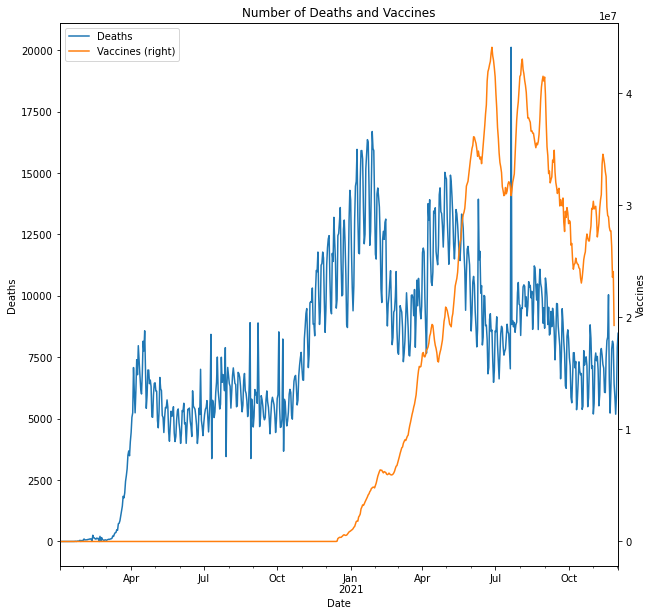

In [19]:
death_df = df1.groupby('Date')['New_deaths'].agg('sum')
vaccn_df = df1.groupby('Date')['daily_vaccinations'].agg('sum')

# dropping the last 5 results because the data has not been updated
# so the graph shows a drop in vaccination numbers
vaccn_df.drop(vaccn_df.tail(5).index,inplace=True)


ax1 = death_df.plot(
    kind = 'line',
    figsize = (10,10),
    label = 'Deaths',
    legend = True
)


ax2 = vaccn_df.plot(
    ax = ax1,
    kind = 'line',
    secondary_y = True,
    label = 'Vaccines',
    legend = True
)
plt.title('Number of Deaths and Vaccines')
ax1.set_ylabel('Deaths')
ax2.set_ylabel('Vaccines')



We can observe that as more vaccines have been admininstered, there has been a downward trend for the number of deaths since April 2021. 

**2. For each country, how many cases do they have per 10,000 people?**

We will plot the data on a world map to observe any pattern.  

We will group each country based on total cases they have had and merge with population_df and create a column for case per 10,000 people. 

In [20]:
df2 = cases_df.groupby('Country')['New_cases'].agg('sum')
df2 = df2.to_frame().reset_index()
df2 = df2.rename(columns={'New_cases': 'Total Cases'})

# merging with population_df on Country column
df2 = pd.merge(df2, population_df, how = 'outer', on=['Country'])

#dropping the columns that will not be required
df2 = df2.drop(
    ['density_sq_km'],
     axis = 1 
)

After the merge we can see some countries have some missing values because of differing names. For example we have case numbers for Ivory Coast and population number for Côte d’Ivoire. We will copy the data to one row and delete the duplicate rows. 

In [21]:
#replacing the NaN value with 0 
df2['Total Cases'] = df2['Total Cases'].fillna(0)
df2['2021 Population'] = df2['2021 Population'].fillna(0)

#updating the missing values from other rows where the value exists but the country name is different
#also dropping the row of countries with multiple entries
df2.at[240,'Total Cases']='6121757.0' #Iran
df2.at[245,'Total Cases']='61752.0' #Ivory Coast
df2.at[249,'Total Cases']='538647.0' #Bolivia
df2.at[263,'Total Cases']='15111.0' #Brunei
df2.at[262,'Total Cases']='38393.0' #Cape Verde
df2.at[252,'Total Cases']='75163.0' #Laos
df2.at[253,'Total Cases']='461157.0' #Palestine
df2.at[238,'Total Cases']='9703107.0' #Russia
df2.at[243,'Total Cases']='457612.0' #South Korea
df2.at[248,'Total Cases']='48267.0' #Syria
df2.at[241,'Total Cases']='10276011.0' #UK
df2.at[242,'Total Cases']='26270.0' #Tanzania
df2.at[237,'Total Cases']='48282078.000' #USA
df2.at[257,'Total Cases']='71361.0' #Trinidad and Tobago
df2.at[239,'Total Cases']='1252590.0' #Vietnam
df2.at[244,'Total Cases']='431945.0' #Venezuela
df2.at[246,'Total Cases']='0.0' #North Korea
df2.at[250,'Total Cases']='2193289.0' #Czech Republic
df2.at[254,'Total Cases']='364433.0' #Moldova
df2.at[255,'Total Cases']='275965.0' #Boznia & Herzegovia
df2.at[256,'Total Cases']='6442.0' #Guinea-Bissau
df2.at[258,'Total Cases']='6442.0' #Timor-Leste
df2.at[259,'Total Cases']='61188.0' #Reunion
df2.at[264,'Total Cases']='3731.0' #Sao Tome
df2.at[265,'Total Cases']='17414.0' #Curacao
df2.at[266,'Total Cases']='0.0' #Micronesia
df2.at[267,'Total Cases']='4141.0' #Antigua and Barbadua
df2.at[268,'Total Cases']='958.0' #Northern Mariana Island
df2.at[269,'Total Cases']='2786.0' #Saint Kitts and Nevis
df2.at[270,'Total Cases']='3096.0' #Turks Island
df2.at[271,'Total Cases']='454.0' #Walis and Futuna
df2.at[272,'Total Cases']='1672.0' #Saint Barthelemy
df2.at[273,'Total Cases']='85.0' #Saint Pierre And Miquelon
df2.at[274,'Total Cases']='79.0' #Falkland Islands	


#dropping the duplicate rows
df2 = df2.drop([7, 24, 26, 30, 34, 50, 52, 53, 54, 55, 68, 89, 98, 114, 
                135, 154, 170, 171, 173, 175, 177, 179, 182, 186, 207, 
                210, 211, 215, 219, 224, 226, 230, 232, 236], errors = 'ignore')

#removing all countries with no iso_code
df2.dropna(subset=['iso_code'], inplace=True)


We will add a column that has the cases per 10,000 people

In [22]:
df2['Cases Per 10,000'] = df2['Total Cases']/(df2['2021 Population']/10000)


We will plot the data on a world map now.

<AxesSubplot:title={'center':'Covid Cases per 10,000 People for Each Country'}>

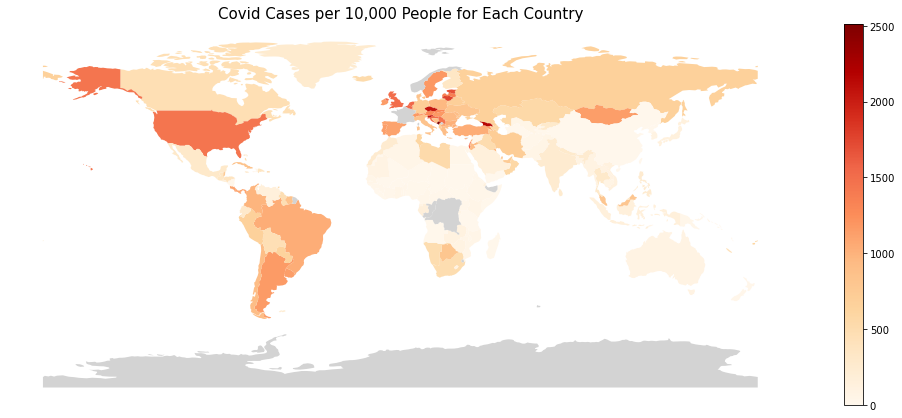

In [23]:
#plotting on a geomap
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.rename({'iso_a3': 'iso_code'}, axis=1, inplace=True)
world = world.merge(df2, on=['iso_code'], how='left')

#replacing the iso_code that have missing values
world['iso_code'] = np.where(world['name']=='France', 'FRA', world['iso_code'])
world['iso_code'] = np.where(world['name']=='Norway', 'NOR', world['iso_code'])


fig, ax_world = plt.subplots(1, figsize=(18, 7))
ax_world.set_title(
    'Covid Cases per 10,000 People for Each Country', 
    fontsize = 15
)
ax_world.axis('off')
world.plot(
    column='Cases Per 10,000', 
    legend=True,
    ax=ax_world,
    cmap='OrRd',
    missing_kwds={"color": "lightgrey"}  #countries that don't have data will be greyed out
)


We can observe that USA, the European countries and South American countries had the most cases per 10,000 people. African countries and South Asian countries had very low cases per 10,000 people .

**3. How does the GDP of a country relate to how many cases they have?**

Analysing how the relation between the GDP per capita of a country and how many cases they had. 

We will be using df2 from the previous analysis since data has already been cleaned and merge the income column from income_df.

In [24]:
df3 = df2[['Country', 'Total Cases', 'iso_code']]

#merging with income_df to obtain the income column
df3 = df3.merge(income_df, on=['iso_code'], how='left')

#dropping the second country column
df3.drop(df3.columns[3],axis=1,inplace=True)

df3.rename({'Country_x': 'Country'}, axis=1, inplace=True)
df3 = df3.replace(0, np.nan)



For our scatter plot, we will be using the log of 'Total Cases' and '2020 Income' because the original values are very large which will result in skewed charts.

In [25]:
df3['log_cases'] = np.log(df3['Total Cases'])
df3['log_income'] = np.log(df3['2020 Income'])

Some countries have no information on their income so they will be omitted. 

In [26]:
df3 = df3.dropna() 

Text(0.5, 1.0, 'Relationship between Income of a Country and Covid-19 Cases')

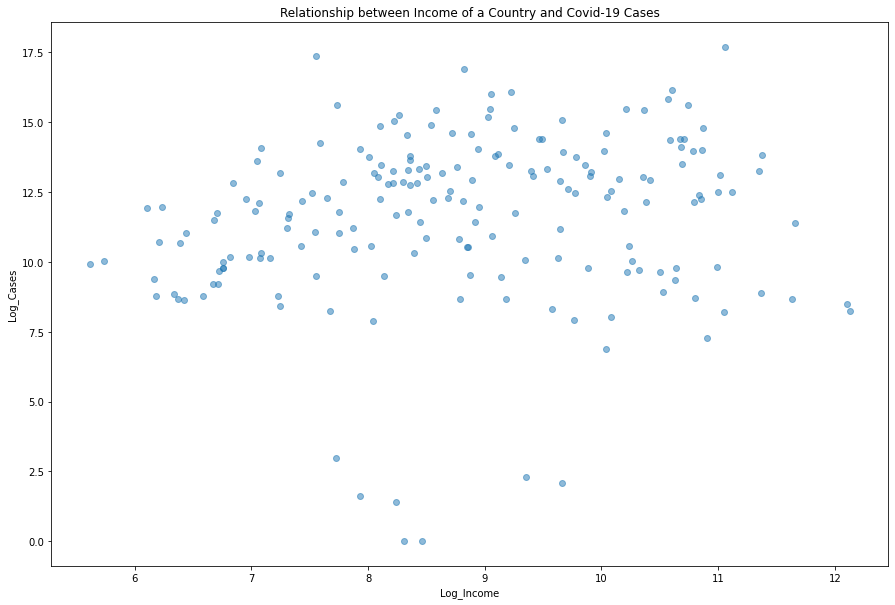

In [27]:
# Scatter plot 
plt.figure(figsize=(15, 10))
plt.scatter('log_income', 'log_cases', alpha =0.5, data=df3)
plt.xlabel("Log_Income")
plt.ylabel("Log_Cases")
plt.title("Relationship between Income of a Country and Covid-19 Cases")



There is a very weak positive correlation between income and cases which may be due to the fact that richer countries have more access to testing kits and better health infrastructure to report the results on a regular basis. 

**4. What effect does population density have on how many cases a country has?**

For this analysis, we will focus whether the population density has an effect on the number of cases in a country. We will categorise the density of a population into three parts(Low, Medium and High) and see the effect on a line chart.

In [28]:
#Adding the iso_code column to cases_df from vax_df
df4 = pd.merge(cases_df, population_df, how = 'left', on=['Country'])
df4[df4.isnull().any(axis=1)]


,Date,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,iso_code,2021 Population,density_sq_km
4900,2020-01-03,Antigua and Barbuda,0,0,0,0,NaN,NaN,NaN
4901,2020-01-04,Antigua and Barbuda,0,0,0,0,NaN,NaN,NaN
4902,2020-01-05,Antigua and Barbuda,0,0,0,0,NaN,NaN,NaN
4903,2020-01-06,Antigua and Barbuda,0,0,0,0,NaN,NaN,NaN
4904,2020-01-07,Antigua and Barbuda,0,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
163795,2021-11-28,Wallis and Futuna,0,454,0,7,NaN,NaN,NaN
163796,2021-11-29,Wallis and Futuna,0,454,0,7,NaN,NaN,NaN
163797,2021-11-30,Wallis and Futuna,0,454,0,7,NaN,NaN,NaN
163798,2021-12-01,Wallis and Futuna,0,454,0,7,NaN,NaN,NaN


Some countries have null density which we will drop.

In [29]:
df4.dropna(subset = ['density_sq_km'], inplace = True)


We will add a column which will describe whether the country has a low, medium or high density of population. 

* Low = 0-100 density_sq_km
* Medium = 101-500 density_sq_km
* High =  500+ density_sq_km

In [30]:
conditions = [
    (df4['density_sq_km'] >= 0) & (df4['density_sq_km'] <= 50),
    (df4['density_sq_km'] > 50) & (df4['density_sq_km'] <=100),
    (df4['density_sq_km'] >= 100)]

choices = ['Low', 'Medium', 'High']

df4['Population Density'] = np.select(conditions, choices, default=None)


We will group the new_cases based on population density

In [31]:
df4 = df4.groupby(['Population Density', 'Date'])['New_cases'].sum()
df4 = df4.to_frame().reset_index()



We will split the dataframe based on population density and plot them on the same axis.

In [32]:
low_df = df4[df4['Population Density'] == 'Low']
medium_df = df4[df4['Population Density'] == 'Medium']
high_df = df4[df4['Population Density'] == 'High']


Text(0, 0.5, 'Cases')

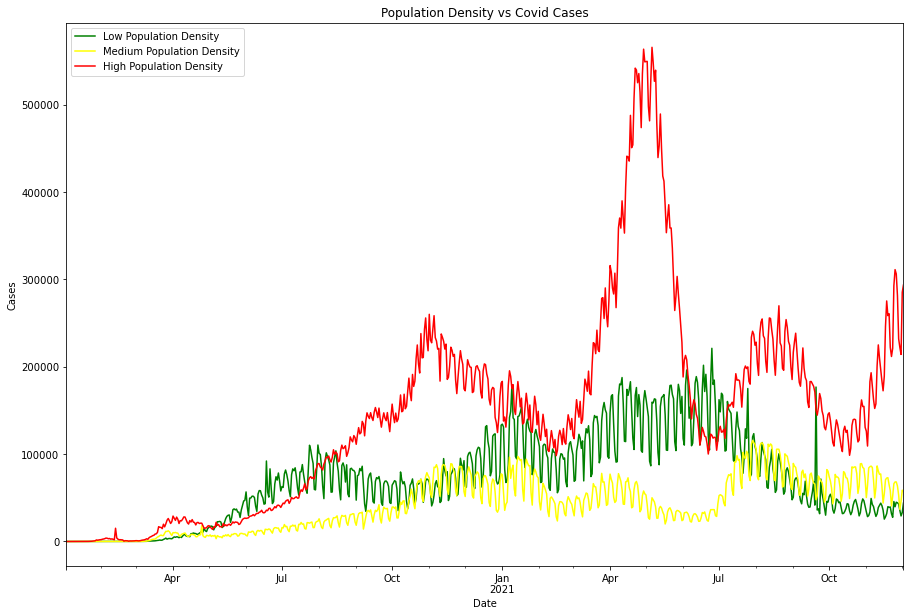

In [33]:
axes = low_df.plot( 
    kind = 'line',
    x = 'Date',
    y = 'New_cases',
    color = 'green'
)

medium_df.plot(
    ax = axes, 
    kind = 'line',
     x = 'Date',
    y = 'New_cases',
    color = 'yellow'
)


high_df.plot(
    ax = axes, 
    kind = 'line',
    x = 'Date',
    y = 'New_cases',
    color = 'red',
    figsize = (15,10)
)
plt.legend(["Low Population Density", "Medium Population Density", 'High Population Density'], loc ="upper left")
plt.title('Population Density vs Covid Cases')
plt.ylabel('Cases')

This analysis shows that countries with high population density had more cases than low and medium population density. This is expected since the virus can quickly be transmitted and if there is a high density, more people will be affected. 

**5. How has the vaccine distribution been for countries of different income level compared to population of those countries?**

This analysis will focus on how equal the vaccine distribution has been for countries on different income level compared to the population percentage of a country. The criteria for income classification is based on World Bank's classification. 

In [34]:
#grouping each country based on the latest vaccine data
df5 = vax_df.groupby(['Country', 'iso_code'])['total_vaccinations'].max()
df5 = df5.to_frame().reset_index()

#adding the income column of each country
df5 = pd.merge(df5, income_df, how = 'left', on=['iso_code'])

#adding the population column of each country
df5 = pd.merge(df5, population_df, how = 'left', on=['iso_code'])

#removing null values
df5 = df5.dropna() 

#removing unwanted columns
df5 = df5.drop(
    ['Country_y', 'Country', 'area', 'density_sq_km'],
     axis = 1,
     errors = 'ignore' 
)

df5.rename({'Country_x': 'Country'}, axis=1, inplace=True)


We will group the income based on low, middle and high income countries (Serajuddin, Hamadeh 2020)

In [35]:
conditions = [
    (df5['2020 Income'] >= 0) & (df5['2020 Income'] <= 1036),
    (df5['2020 Income'] > 1036) & (df5['2020 Income'] <4046),
    (df5['2020 Income'] > 4046) & (df5['2020 Income'] <12375),
    (df5['2020 Income'] >= 12375)]

choices = ['Low', 'Lower-Middle', 'Upper-Middle', 'High']

df5['Income Category'] = np.select(conditions, choices, default=None)

In [36]:
#Group by each income category
df5 = df5.groupby(['Income Category'])['total_vaccinations', '2021 Population'].sum()


/tmp/ipykernel_33/4182953638.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df5 = df5.groupby(['Income Category'])['total_vaccinations', '2021 Population'].sum()


Text(0.5, 1.0, 'Comparison of Vaccine Distribution in Delation to Population Distribution')

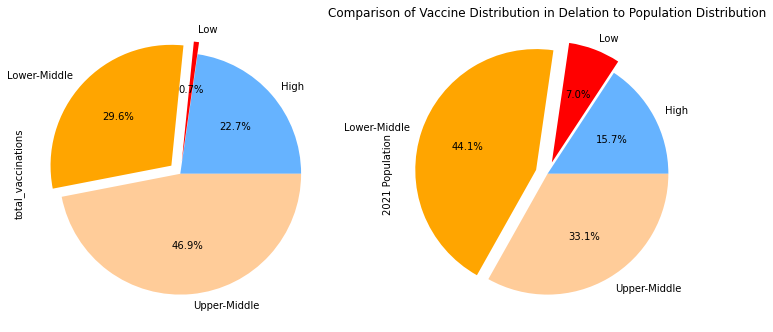

In [37]:
#plotting the data on a pie chart
df5.plot(
    explode = (0, 0.1, 0.1, 0) ,
    kind='pie',
    subplots = True,
    autopct="%.1f%%",
    figsize=(10,7),
    legend = None, 
    colors = ['#66b3ff','red','orange','#ffcc99'],
    
)

plt.tight_layout()
plt.title('Comparison of Vaccine Distribution in Delation to Population Distribution')


Stark inequality can be observed in these charts. Low and lower-middle income countries have received only 1/3rd of the vaccine even though they make up more than half the worlds population. Richer countries have received almost 75% of all the vaccinations even though they make up less than half the worlds population.

**6. Focussing on the inequality in vaccine distribuion,  let us see how big is the vaccine distribution gap between a high income and a low income country.**

We will be comparing the distrbution of Afghanistan and USA. These are two countries on opposite ends of the income spectrum.

In [38]:
# creating a dataframe with Afghanistans vaccine data and adding their population data
afg_df = vax_df.loc[vax_df['Country'] == 'Afghanistan']
afg_df = pd.merge(afg_df, population_df, how = 'left', on=['iso_code'])

#dropping unnecessary columns and renaming columns
afg_df = afg_df.drop(['Country_y', 'area', 'density_sq_km'], axis = 1, errors = 'ignore')
afg_df.rename({'Country_x': 'Country'}, axis=1, inplace=True)

#repeating the process for USA
usa_df = vax_df.loc[vax_df['Country'] == 'United States']
usa_df = pd.merge(usa_df, population_df, how = 'left', on=['iso_code'])
usa_df = usa_df.drop(['Country_y', 'area', 'density_sq_km'], axis = 1, errors = 'ignore')
usa_df.rename({'Country_x': 'Country'}, axis=1, inplace=True)




In [39]:
#adding the percentage of population vaccinated for each country

usa_df['% vaccinated'] = (usa_df['people_vaccinated']/usa_df['2021 Population'])*100
afg_df['% vaccinated'] = (afg_df['people_vaccinated']/afg_df['2021 Population'])*100

#Afghanistan does not update their data as frequently as USA 
#therefore there are multiple NaN values we will discard
afg_df = afg_df.dropna(subset = ['% vaccinated'])


Text(0.5, 1.0, '% of Population Vaccinated for USA and Afghanistan')

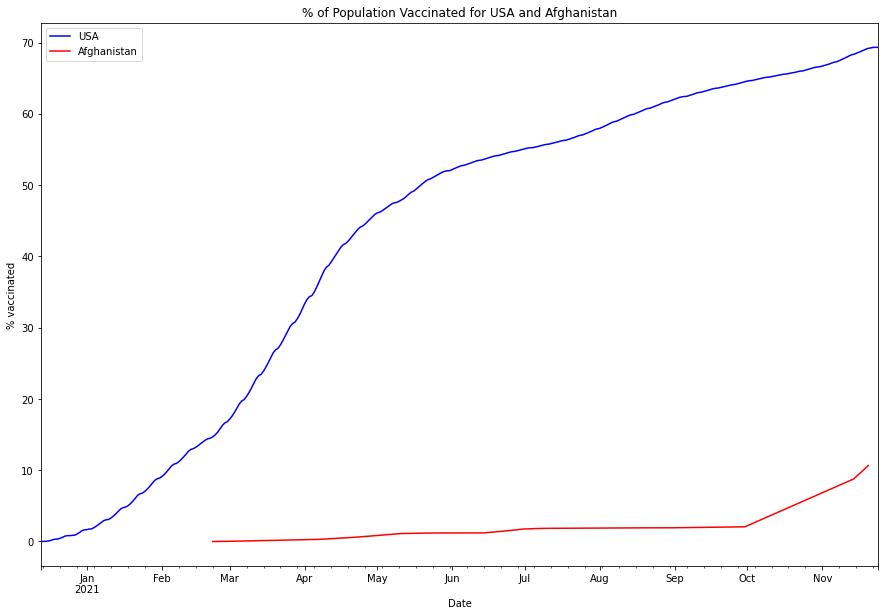

In [40]:
#plotting two line charts on the same axes
axes = usa_df.plot( 
    kind = 'line',
    x = 'Date',
    y = '% vaccinated',
    color = 'blue',
)

afg_df.plot(
    ax = axes, 
    kind = 'line',
    x = 'Date',
    y = '% vaccinated',
    color = 'red',
    ylabel = '% vaccinated',
    figsize = (15,10)
)
plt.legend(["USA", "Afghanistan"], loc ="upper left")
plt.title('% of Population Vaccinated for USA and Afghanistan')

We can observe how big the difference is between the countries. USA has been able to vaccinate their population much earlier than Afghanistan highlighting how poorer countries has been affected harder than rich countries. 

### **4. Conclusion**

The pandemic has brought in a whole new set of challenges for the world and the health system. With the introduction of the vaccine, the number of deaths has gone down but unequal distribution will lead to other challenges some of which we are already observing with the virus taking new shape(WHO 2021). This is resulting in prolonging the pandemic and costing the world by widening the inequality and pushing more people into poverty. 

One way the World Health Organisation is tackling this challenge is by trying to ensure equitable access to vaccines, test kits and treatments for all countries, especially the low income ones through the COVAX scheme (WHO 2021). More countries are pledging to donate their excess vaccines and sending as much help as possible. 

One can only hope to see the light at the end of the tunnel when we will able to move without worrying about restrictions, hop on a flight without having to carry out expensive tests and visit iconic places without having to stay locked in a small room until there is confirmation we do not carry the invisible being. 

### **5. References**

Centers for Disease Control and Prevention 2021, accessed 4 December 2021, 
<https://www.cdc.gov/coronavirus/2019-ncov/faq.html#Basics>

Australian Government Department of Health, accessed 4 December 2021, 
<https://www.health.gov.au/initiatives-and-programs/covid-19-vaccines/approved-vaccines/how-they-work#how-the-vaccines-work>

Hyder AA, Hyder MA, Nasir K, Ndebele P, 'Inequitable COVID-19 vaccine distribution and its effects'. *Bulletin of the World Health Organization*, 99:406–406A , accessed 5 December 2021, <https://www.who.int/bulletin/volumes/99/6/21-285616.pdf>.

World Health Organization 2021, accessed 2 December 2021, <https://covid19.who.int/info/>

Sharma, R, 2021, accessed 30 November 2021, <https://www.kaggle.com/rsrishav/world-population>

The World Bank, accessed 1 December 2021, <https://data.worldbank.org/indicator/NY.GDP.PCAP.CD>

Saurabh, 2021, accessed 4 December 2021, <https://www.kaggle.com/saurabhag12/country-vaccinations>

Serajuddin, U, Hamadeh, N 2020, 'New World Bank country classifications by income level: 2020-2021', *World Bank Blogs*, Data Blog, 1 July 2020, accessed 6 December 2021, <https://blogs.worldbank.org/opendata/new-world-bank-country-classifications-income-level-2020-2021> 

World Health Orginaztion 2021, accessed 6 December 2021, 
<https://www.who.int/news/item/28-11-2021-update-on-omicron>

World Health Orginaztion 2021, accessed 6 December 2021, 
<https://www.who.int/initiatives/act-accelerator/covax>

